#  **Import** **Libaries**

In [54]:
!pip install --q nltk
!pip install arabic_reshaper python-bidi

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arabic_reshaper
import sklearn
import itertools
import random
import string
import re

from bidi.algorithm import get_display
from pandas import DataFrame

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import WordPunctTokenizer

from nltk.stem.isri import ISRIStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC


from sklearn import tree



import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

lancaster = LancasterStemmer()

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#  Data Loading

In [3]:
from google.colab import files
uploaded = files.upload()

Saving finaldata modfied.xlsx to finaldata modfied.xlsx


In [4]:
path = "finaldata modfied.xlsx"
df_labeled = pd.read_excel(path)
df_labeled.head()

,Content,label
0,اغبي برنامج في العالم .. كيف يشتغل بس مع للنا...,0
1,افشل تحديث,0
2,افشل تطبيق خدمات مصرفية علي وجة الارض,0
3,افضل السيئين,2
4,افضل برنامج للمعاملات السريعة,1


In [5]:
df_labeled['Language'] = np.nan
df_labeled.loc[:1554,'Language'] = 'AR'
df_labeled.loc[1555:,'Language'] = 'EN'

Stopwords Loading

In [6]:
uploaded = files.upload()
file_name = 'allstop.txt'
uploaded[file_name].decode('utf-8').split('\r\n');

Saving allstop.txt to allstop.txt


# **Arabic NLP Preprocessing**


In [7]:
def stopWordRemove_ar(text):
  my_st_file = open('allstop.txt')
  my_list = my_st_file.read()
  needed_word = []
  words = word_tokenize(text)
  for w in words:
    if w  not in (my_list):
       needed_word.append(w)
  filterd_sentence = ' '.join(needed_word)
  return filterd_sentence

In [8]:
def stemming_ar(text):
 st = ISRIStemmer()
 stemmed_words = []
 words = word_tokenize(text)
 for w in words :
  stemmed_words.append(st.stem(w))
 stemmed_sentence =' '.join(stemmed_words)
 return stemmed_sentence

In [9]:
punctuations = '''٠١٢٣٤٥٦٧٨٩1234567890÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

def normlizeArabic_ar(text):
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)

    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    noise = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    #text = re.sub('[a-zA-Z]',' ', text)
    text = re.sub(noise,'',text)
    return text

# **English NLP Preprocessing**


In [10]:
def stopWordRemove_en(text):
 text = re.sub('[^a-zA-Z]',' ', text)
 text = text.lower()
 text = text.split()
 text = [word for word in text if word not in stopwords.words('english')]
 text = ' '.join(text)
 return text

In [11]:
def stemSentence_en(text):
 token_words=word_tokenize(text)
 token_words
 stem_sentence=[]
 for word in token_words:
  stem_sentence.append(lancaster.stem(word))
  stem_sentence.append(" ")
 return "".join(stem_sentence)

In [12]:
def normlization_ar(r):

  text = stemming_ar(r['Content'])
  text = stopWordRemove_ar(r['Content'])
  text = normlizeArabic_ar(r['Content'])
  return text

In [13]:
def normlization_en(r):
  text = stopWordRemove_en(r['Content'])
  text = stemSentence_en(r['Content'])

  return text

# **Apply preprocessing**

In [14]:
def prepareDataSet(data):
    sentence = []

    for index, r in data.iterrows():

      if (r['Language'] == 'AR'):
       text = normlizeArabic_ar(stemming_ar((r['Content'])))

      else:
       text = stemSentence_en(r['Content'])


      if r['label'] == 0:
        sentence.append([text, '0'])
      elif r['label'] == 1:
        sentence.append([text, '1'])
      elif r['label'] == 2:
        sentence.append([text, '2'])

    df_sentence = DataFrame(sentence,columns= ['Content','label'])
    return df_sentence

In [15]:
df_cleaned = prepareDataSet(df_labeled)
df_cleaned

,Content,label
0,اغب رنمج في علم كيف شغل بس مع ناس دخل سود ي ...,0
1,فشل حدث,0
2,فشل طبق خدم صرف علي وجه ارض,0
3,فضل سيء,2
4,فضل رنمج عمل سرع,1
...,...,...
4558,good,1
4559,good,1
4560,good,1
4561,good,1


# Vectorize the Text

In [16]:
X = df_cleaned['Content']
y = df_cleaned['label']
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Train a Model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [18]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       448
           1       0.95      0.88      0.92       427
           2       0.67      0.05      0.10        38

    accuracy                           0.89       913
   macro avg       0.82      0.64      0.64       913
weighted avg       0.89      0.89      0.88       913



In [19]:
model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       448
           1       0.96      0.88      0.92       427
           2       0.00      0.00      0.00        38

    accuracy                           0.90       913
   macro avg       0.60      0.62      0.61       913
weighted avg       0.87      0.90      0.88       913



# Upload the New Unlabeled File

In [20]:
uploaded = files.upload()

Saving unlabeled.xlsx to unlabeled.xlsx


# **Basic unlabeled_Data Overview**




In [21]:
path = 'unlabeled.xlsx'
df_unlabeled = pd.read_excel(path)
df_unlabeled.head()

,Unnamed: 0,reviewId,userName,userImage,Content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,0,7c722c6b-a3ad-44d7-8197-db81de702d2a,Sideeg Salah,https://play-lh.googleusercontent.com/a/ALm5wu...,Its very convenient and good but needs update ...,3,0,4.42,2022-11-01 17:08:51,NaN,NaT
1,1,ab69a787-0a96-43a3-b5e6-d68a3666b9b9,رجاء عبد القادر,https://play-lh.googleusercontent.com/a/ALm5wu...,You don't have enough servers to play it fast ...,1,0,NaN,2022-11-01 09:03:19,NaN,NaT
2,2,c725a7bb-b4a1-4c0f-945e-4f0cf63ce74e,tilal aziz,https://play-lh.googleusercontent.com/a-/ACNPE...,Excellent and useful!,5,0,4.42,2022-11-01 03:28:50,NaN,NaT
3,3,bb842dad-81bd-44cc-aad5-41a057724f14,Abdelkerim Abdelaziz,https://play-lh.googleusercontent.com/a-/ACNPE...,hi working team i think it's superb applicatio...,4,0,4.42,2022-11-01 01:39:43,NaN,NaT
4,4,d396581f-2133-4069-b78f-68570851c4ae,Mohammed Nader,https://play-lh.googleusercontent.com/a/ALm5wu...,تطبيق ضعيف وخدمات سيئة,1,0,4.42,2022-10-31 12:24:49,NaN,NaT


In [22]:
df_unlabeled['Language'] = df_unlabeled['Content'].apply(lambda x: 'AR' if re.search(r'[\u0600-\u06FF]', str(x)) else 'EN')

Apply preprocessing to unlabeled data

In [24]:
def clean_unlabeled_data(data):
    cleaned_sentences = []

    for index, r in data.iterrows():
        if r['Language'] == 'AR':
            text = normlizeArabic_ar(stemming_ar(str(r['Content'])))
        else:
            text = stemSentence_en(str(r['Content']))
        cleaned_sentences.append(text)


    data['cleaned'] = cleaned_sentences
    return data



Convert to Vector and Predict

In [27]:
X_unlabeled = vectorizer.transform(df_unlabeled['cleaned'])
predicted_labels = model.predict(X_unlabeled)

df_unlabeled['Predicted_Label'] = predicted_labels
df_unlabeled[['Content', 'Predicted_Label']].head()


,Content,Predicted_Label
0,Its very convenient and good but needs update ...,1
1,You don't have enough servers to play it fast ...,0
2,Excellent and useful!,1
3,hi working team i think it's superb applicatio...,1
4,تطبيق ضعيف وخدمات سيئة,0


In [28]:
df_unlabeled = clean_unlabeled_data(df_unlabeled)
df_unlabeled.head()
df_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6731 entries, 0 to 6730
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            6731 non-null   int64         
 1   reviewId              6731 non-null   object        
 2   userName              6731 non-null   object        
 3   userImage             6731 non-null   object        
 4   Content               6728 non-null   object        
 5   score                 6731 non-null   int64         
 6   thumbsUpCount         6731 non-null   int64         
 7   reviewCreatedVersion  5728 non-null   float64       
 8   at                    6731 non-null   datetime64[ns]
 9   replyContent          1846 non-null   object        
 10  repliedAt             1846 non-null   datetime64[ns]
 11  Language              6731 non-null   object        
 12  cleaned               6731 non-null   object        
 13  Predicted_Label   

Remove rows where Predicted_Label == 2 (Neutral)

In [29]:
df_unlabeled = df_unlabeled[df_unlabeled['Predicted_Label'] != "2"]
df_unlabeled.reset_index(drop=True, inplace=True)


Sentiment Distribution

In [30]:
print(df_unlabeled['Predicted_Label'].value_counts())
print(df_unlabeled['Predicted_Label'].dtype)


Predicted_Label
0    4577
1    2068
Name: count, dtype: int64
object


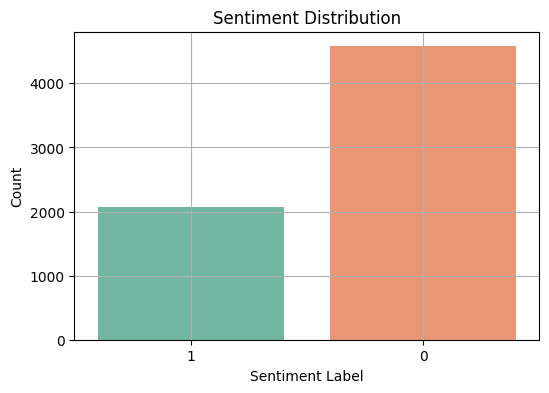

In [31]:
plt.figure(figsize=(6,4))
sns.countplot(x='Predicted_Label', data=df_unlabeled, palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()

Top Words

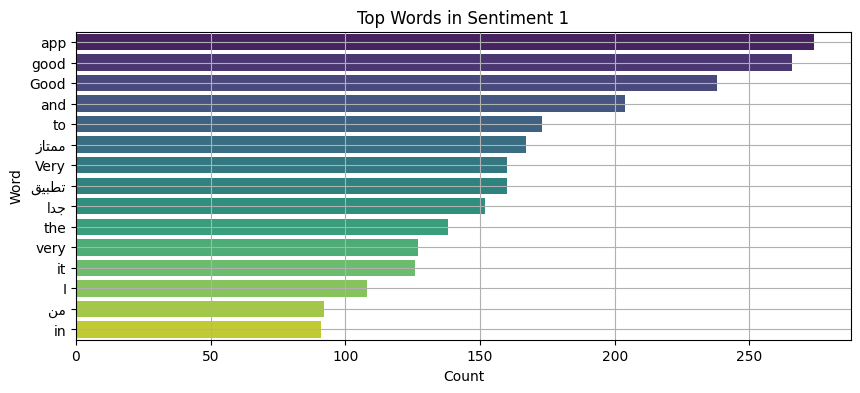

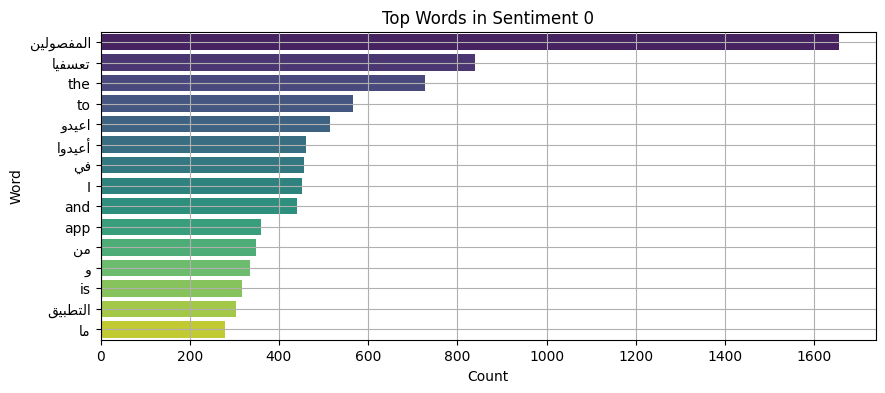

In [ ]:
def reshape_arabic(word):
    try:
        reshaped_text = arabic_reshaper.reshape(word)
        bidi_text = get_display(reshaped_text)
        return bidi_text
    except:
        return word

for label in df_unlabeled['Predicted_Label'].unique():
    top_words_df = get_top_n_words(df_unlabeled[df_unlabeled['Predicted_Label'] == label]['Content'])


    top_words_df['word'] = top_words_df['word'].apply(reshape_arabic)

    plt.figure(figsize=(10,4))
    sns.barplot(x='count', y='word', data=top_words_df, palette='viridis')
    plt.title(f"Top Words in Sentiment {label}")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.grid(True)
    plt.show()


# Split the data and Feature Engineering

In [46]:
X = df_unlabeled['cleaned']
y = df_unlabeled['Predicted_Label']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Model Training and Evaluation**

In [48]:
pipe = make_pipeline(
    TfidfVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000))

param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

model = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)

print(f" Accuracy score: {accuracy_score(Y_test, prediction):.2f}")
print(" Classification Report:\n")
print(classification_report(Y_test, prediction))

 Accuracy score: 0.97
 Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       915
           1       0.96      0.93      0.94       414

    accuracy                           0.97      1329
   macro avg       0.96      0.96      0.96      1329
weighted avg       0.97      0.97      0.97      1329



In [50]:
pipe = make_pipeline(TfidfVectorizer(),
                    MultinomialNB())
pipe.fit(X_train,Y_train)
prediction = pipe.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.96
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       915
           1       0.97      0.89      0.93       414

    accuracy                           0.96      1329
   macro avg       0.96      0.94      0.95      1329
weighted avg       0.96      0.96      0.96      1329



In [51]:
pipe = make_pipeline(TfidfVectorizer(),
                     SVC())
param_grid = {'svc__kernel': ['rbf', 'linear', 'poly'],
             'svc__gamma': [0.1, 1, 10, 100],
             'svc__C': [0.1, 1, 10, 100]}

svc_model = GridSearchCV(pipe, param_grid, cv=3)
svc_model.fit(X_train, Y_train)

prediction = svc_model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.97
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       915
           1       0.99      0.93      0.96       414

    accuracy                           0.97      1329
   macro avg       0.98      0.96      0.97      1329
weighted avg       0.97      0.97      0.97      1329



# **Model Comparison and Metrics**

In [55]:
model_results = {}

model_results['Logistic Regression'] = (
    model.predict(X_test),
    model.best_estimator_
)

nb_pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_pipe.fit(X_train, Y_train)
model_results['Multinomial NB'] = (
    nb_pipe.predict(X_test),
    nb_pipe
)

model_results['SVM'] = (
    svc_model.predict(X_test),
    svc_model.best_estimator_
)


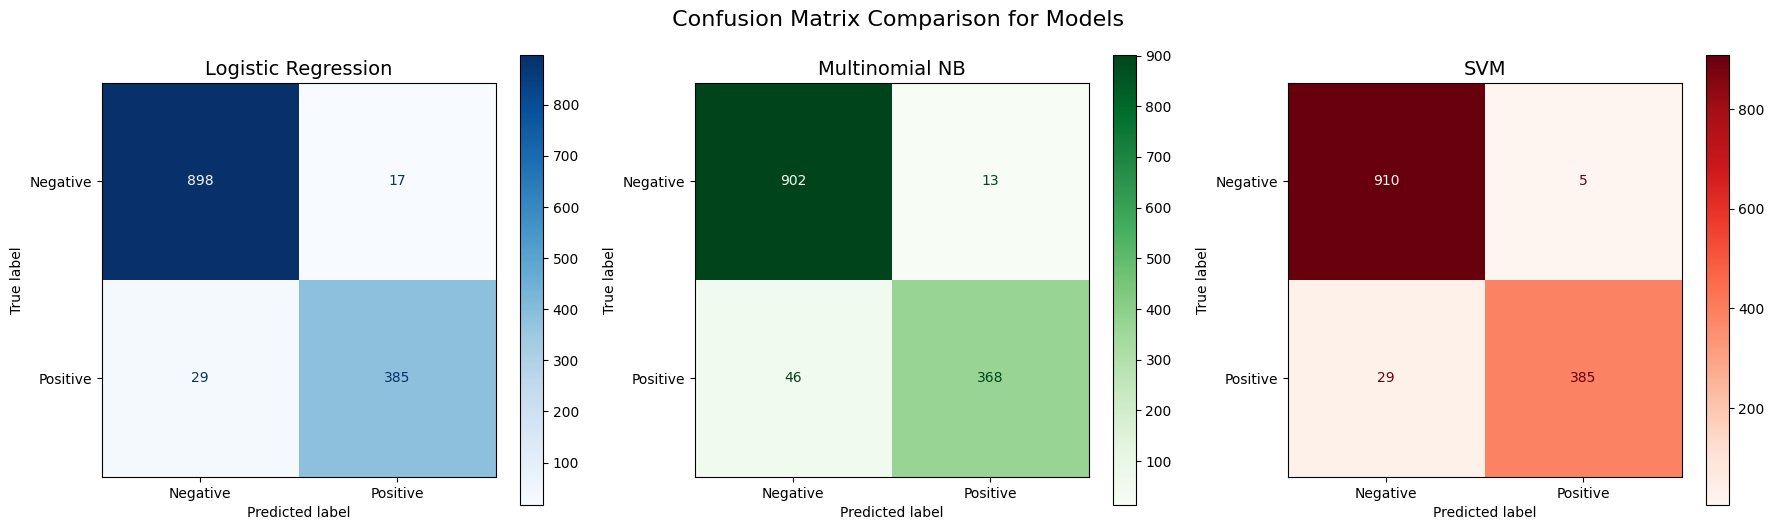

In [56]:
cmap_dict = {
    'Logistic Regression': 'Blues',
    'Multinomial NB': 'Greens',
    'SVM': 'Reds'
}


plt.figure(figsize=(18, 5))
for i, (model_name, (preds, _)) in enumerate(model_results.items()):
    cm = confusion_matrix(Y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    plt.subplot(1, 3, i + 1)
    disp.plot(ax=plt.gca(), cmap=cmap_dict[model_name])
    plt.title(model_name, fontsize=14)
    plt.grid(False)

plt.tight_layout()
plt.suptitle(" Confusion Matrix Comparison for Models", fontsize=16, y=1.05)
plt.show()


In [60]:
print("\n Model Comparison (Accuracy):\n")
for model_name, (preds, _) in model_results.items():
    acc = accuracy_score(Y_test, preds)
    print(f"{model_name:<20}:  Accuracy = {acc:.4f}")



 Model Comparison (Accuracy):

Logistic Regression :  Accuracy = 0.9654
Multinomial NB      :  Accuracy = 0.9556
SVM                 :  Accuracy = 0.9744


Among the three models tested, Support Vector Machine (SVM) achieved the highest accuracy and F1-score, outperforming Logistic Regression and Naive Bayes.
This makes SVM the most effective model for sentiment classification in our Arabic-English app reviews dataset.

In [65]:
def predict_sentiment(text):

    if re.search(r'[\u0600-\u06FF]', text):
        cleaned_text = normlizeArabic_ar(stemming_ar(text))
    else:
        cleaned_text = stemSentence_en(stopWordRemove_en(text))


    pred = svc_model.predict([cleaned_text])[0]


    label_map = {
        "0": " Negative",
        "1": " Positive",

    }

    print(f"\n Input: {text}")
    print(f" Prediction: {label_map[pred]}")


## **Try It Yourself: Sentiment Classifier   جرب النموذج**

In [66]:
predict_sentiment("خدمه تعبانه تعب الموت ومافي فايده")  # Arabic
predict_sentiment("The app is too slow and crashes a lot.")  # English



 Input: خدمه تعبانه تعب الموت ومافي فايده
 Prediction:  Negative

 Input: The app is too slow and crashes a lot.
 Prediction:  Negative
